# Safe Withdrawal Rate Analysis: MSCI World 100% (No Tax)

## Overview

This notebook performs a **Monte Carlo simulation** using **block bootstrap** methodology to analyze the **Safe Withdrawal Rate (SWR)** for a portfolio composed of:
- **100% MSCI World Index (Net Total Return)** (global equities)

> ⚠️ **Tax Assumption**: This simulation assumes **no capital gains tax** is applied on withdrawals. This represents an idealized scenario (e.g., tax-advantaged accounts, jurisdictions with no capital gains tax, or assets held beyond tax-exemption thresholds). For a realistic analysis in taxed environments, withdrawal amounts should be grossed up to account for applicable taxes.

## Methodology

### Block Bootstrap Approach
Unlike traditional Monte Carlo simulations that assume independent returns, the **block bootstrap** preserves the temporal structure and correlations in financial data by:
1. Sampling **consecutive blocks** of historical data (default: 6 months)
2. Randomly concatenating these blocks to create simulated future scenarios
3. Maintaining serial correlation and regime persistence

### Key Features
- **Historical data**: Daily returns from 2000-2025 (MSCI World)
- **Inflation adjustment**: Withdrawals adjusted using Euro area HICP inflation
- **Calendar days**: All calculations use 365 days/year (not trading days)
- **100,000 simulations**: Provides robust statistical estimates
- **30-year horizon**: Standard retirement planning period
- **No capital gains tax**: Withdrawals are not subject to any taxation

### What This Analysis Provides
1. **Success rate**: Probability that portfolio survives 30 years
2. **Portfolio evolution**: Percentile bands (5th, 25th, 50th, 75th, 95th)
3. **Sensitivity analysis**: Impact of different withdrawal rates (2%-5%)
4. **Failure analysis**: Distribution of depletion years for failed scenarios

### Data Sources
- **Equities**: MSCI World Net Total Return Index (EUR) - includes reinvested dividends net of withholding taxes
- **Inflation**: Eurostat HICP for Euro area

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Tuple, List, Dict
from datetime import datetime
from joblib import Parallel, delayed

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

---

## 1. Data Loading Functions

These functions load historical price data for:
- **Equity indices**: MSCI World (Net Total Return), MSCI ACWI, MSCI Italy, STOXX Europe 600
- **Bond yields**: BTP 10Y (Italy), Bund 10Y (Germany), OAT 10Y (France)
- **Inflation**: ISTAT FOI (Italy), Eurostat HICP (Italy & Euro area)

> **Note on MSCI indices**: All MSCI indices used are **Net Total Return** versions, which include reinvested dividends after deducting withholding taxes applicable to non-resident investors.

In [2]:
def load_asset_data(base_path: Path) -> Dict[str, pd.DataFrame]:
    """
    Load all asset data from CSV files.
    
    Returns:
        Dictionary with asset names as keys and DataFrames as values
    """
    assets = {}
    
    # MSCI indices
    msci_files = {
        'MSCI_WORLD': 'data/msci/WORLD.csv',
        'MSCI_ACWI': 'data/msci/ACWI.csv',
        'MSCI_ITALY': 'data/msci/ITALY.csv'
    }
    
    for name, path in msci_files.items():
        df = pd.read_csv(base_path / path)
        df.columns = ['date', 'price']
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        assets[name] = df
    
    # STOXX
    df_stoxx = pd.read_csv(base_path / 'data/stoxx/STOXX_SXXGR_DAILY.csv')
    df_stoxx.columns = ['date', 'price']
    df_stoxx['date'] = pd.to_datetime(df_stoxx['date'])
    df_stoxx = df_stoxx.sort_values('date')
    assets['STOXX_SXXGR'] = df_stoxx
    
    # BTP 10Y (Italian bonds)
    df_btp = pd.read_csv(base_path / 'data/bdi/BMK0200/MFN_BMK.D.020.922.0.EUR.210.csv')
    df_btp.columns = ['date', 'yield']
    df_btp['date'] = pd.to_datetime(df_btp['date'])
    df_btp = df_btp.sort_values('date')
    assets['BTP_10Y'] = df_btp
    
    # Bund 10Y (German bonds)
    df_bund = pd.read_csv(base_path / 'data/bund/bbsis/BBSIS_10_YEARS_YIELDS.csv')
    df_bund.columns = ['date', 'yield']
    df_bund['date'] = pd.to_datetime(df_bund['date'])
    df_bund = df_bund.sort_values('date')
    assets['BUND_10Y'] = df_bund
    
    # OAT 10Y (French bonds)
    df_oat = pd.read_csv(base_path / 'data/oat/FRANCE_10_YEARS_DAILY_YIELDS_MERGED_FR10.csv')
    df_oat.columns = ['date', 'yield']
    df_oat['date'] = pd.to_datetime(df_oat['date'])
    df_oat = df_oat.sort_values('date')
    assets['OAT_10Y'] = df_oat
    
    return assets


def load_inflation_data(base_path: Path) -> Dict[str, pd.DataFrame]:
    """
    Load inflation data from CSV files.
    
    Returns:
        Dictionary with inflation series names as keys and DataFrames as values
    """
    inflation = {}
    
    # ISTAT FOI (Italy)
    df_foi = pd.read_csv(base_path / 'data/istat/FOI_MONTHLY.csv')
    df_foi.columns = ['date', 'value', 'base']
    df_foi['date'] = pd.to_datetime(df_foi['date'])
    df_foi = df_foi.sort_values('date')
    inflation['FOI_IT'] = df_foi[['date', 'value']]
    
    # Eurostat HICP
    df_hicp = pd.read_csv(base_path / 'data/eurostat/hicp_it_eu.csv')
    df_hicp['TIME_PERIOD'] = pd.to_datetime(df_hicp['TIME_PERIOD'])
    
    # Filter for Italy and EU
    df_hicp_it = df_hicp[df_hicp['geo'] == 'Italy'][['TIME_PERIOD', 'OBS_VALUE']].copy()
    df_hicp_it.columns = ['date', 'value']
    df_hicp_it = df_hicp_it.sort_values('date')
    inflation['HICP_IT'] = df_hicp_it
    
    df_hicp_eu = df_hicp[df_hicp['geo'] == 'Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)'][['TIME_PERIOD', 'OBS_VALUE']].copy()
    df_hicp_eu.columns = ['date', 'value']
    df_hicp_eu = df_hicp_eu.sort_values('date')
    inflation['HICP_EU'] = df_hicp_eu
    
    return inflation

---

## 2. Data Preparation Functions

### Return Calculations
- **Equity returns**: Log returns calculated as `ln(P_t / P_{t-1})`
- **Bond returns**: Simplified as `yield / 365` (income return only, ignoring duration effects)
- **Inflation**: Month-over-month percentage change, then converted to daily

### Key Notes
- All data uses **calendar days** (365 days/year), not trading days (252 days/year)
- Monthly inflation is divided by actual days in month for precision
- Forward-fill is used to handle missing data (weekends, holidays)

In [3]:
def calculate_daily_returns(df: pd.DataFrame, price_col: str = 'price') -> pd.DataFrame:
    """
    Calculate daily log returns from price data.
    """
    df = df.copy()
    df['return'] = np.log(df[price_col] / df[price_col].shift(1))
    return df.dropna()


def calculate_bond_returns(df: pd.DataFrame, yield_col: str = 'yield') -> pd.DataFrame:
    """
    Calculate daily returns from bond yields using simple approximation.
    Daily return ≈ yield/365 - duration * Δyield
    Simplified: just use yield/365 for income return
    """
    df = df.copy()
    df['return'] = df[yield_col] / 100 / 365  # Simple daily yield return (calendar days)
    return df


def calculate_inflation_rate(df: pd.DataFrame, value_col: str = 'value') -> pd.DataFrame:
    """
    Calculate monthly inflation rate from price index.
    """
    df = df.copy()
    df['inflation'] = (df[value_col] / df[value_col].shift(1) - 1)
    return df.dropna()


def merge_to_common_dates(assets_dict: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Merge all asset returns to common dates.
    """
    merged = None
    
    for name, df in assets_dict.items():
        df_temp = df[['date', 'return']].copy()
        df_temp.columns = ['date', name]
        
        if merged is None:
            merged = df_temp
        else:
            merged = pd.merge(merged, df_temp, on='date', how='outer')
    
    merged = merged.sort_values('date')
    return merged


def upsample_inflation_to_daily(inflation_df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Convert monthly inflation to daily by dividing by days in month.
    """
    daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    daily_df = pd.DataFrame({'date': daily_dates})
    
    # Create year-month column for merging
    daily_df['year_month'] = daily_df['date'].dt.to_period('M')
    daily_df['days_in_month'] = daily_df['date'].dt.days_in_month
    
    inflation_df = inflation_df.copy()
    inflation_df['year_month'] = inflation_df['date'].dt.to_period('M')
    
    # Merge
    merged = pd.merge(daily_df, inflation_df[['year_month', 'inflation']], 
                      on='year_month', how='left')
    
    # Convert monthly to daily (divide by actual days in month)
    merged['daily_inflation'] = merged['inflation'] / merged['days_in_month']
    merged = merged[['date', 'daily_inflation']]
    merged.columns = ['date', 'inflation']
    
    return merged

---

## 3. Block Bootstrap Implementation

### Why Block Bootstrap?
Financial returns exhibit:
- **Volatility clustering**: High/low volatility periods persist
- **Serial correlation**: Today's return affects tomorrow's
- **Market regimes**: Bull/bear markets last for extended periods

### How It Works
1. Divide historical data into overlapping blocks (default: 6 months = ~180 days)
2. Randomly sample blocks with replacement
3. Concatenate to create 30 years (10,950 days) of simulated returns
4. Preserve within-block correlations and patterns

### Block Size Parameter
- **Smaller blocks** (1-3 months): More independent, less structure preservation
- **Larger blocks** (6-12 months): Better structure preservation, less variation
- **Default**: 6 months balances both objectives

In [4]:
def block_bootstrap_sample(
    data: pd.DataFrame,
    block_size_months: int = 6,
    n_years: int = 30,
    rng: np.random.Generator = None
) -> pd.DataFrame:
    """
    Generate a block bootstrap sample from historical data.
    
    Args:
        data: DataFrame with date index and return columns
        block_size_months: Size of each block in months
        n_years: Number of years to generate
        rng: numpy random Generator for reproducibility (optional)
    
    Returns:
        DataFrame with bootstrapped returns
    """
    if rng is None:
        rng = np.random.default_rng()
    
    block_size_days = block_size_months * 30  # Approximate calendar days per month
    n_days_needed = n_years * 365  # Calendar days per year
    
    # Adjust block size if data is not long enough
    max_block_size = len(data) - 1
    if block_size_days > max_block_size:
        original_block_size = block_size_days
        block_size_days = max(30, max_block_size // 2)  # At least 1 month
        print(f"  Warning: Reducing block size from {original_block_size} to {block_size_days} days due to limited data")
    
    n_blocks_needed = int(np.ceil(n_days_needed / block_size_days))
    
    # Ensure we have enough data
    n_possible_blocks = len(data) - block_size_days + 1
    
    if n_possible_blocks < 1:
        raise ValueError(
            f"Not enough data for block size {block_size_days} days. "
            f"Available data: {len(data)} days. "
            f"Need at least {block_size_days} days."
        )
    
    # Randomly select block start positions using the provided RNG
    block_starts = rng.integers(0, n_possible_blocks, size=n_blocks_needed)
    
    # Concatenate blocks
    samples = []
    for start in block_starts:
        block = data.iloc[start:start + block_size_days].copy()
        samples.append(block)
    
    result = pd.concat(samples, ignore_index=True)
    
    # Trim to exact length needed
    result = result.iloc[:n_days_needed]
    
    # Reset index to be sequential days
    result = result.reset_index(drop=True)
    
    return result

---

## 4. Load Historical Data

Loading all available asset classes and inflation data from CSV files.

In [5]:
# Set base path
BASE_PATH = Path('..')

# Load data
print("Loading asset data...")
assets = load_asset_data(BASE_PATH)

print("Loading inflation data...")
inflation_data = load_inflation_data(BASE_PATH)

# Show available assets
print("\nAvailable assets:")
for name, df in assets.items():
    print(f"  {name}: {len(df)} observations from {df['date'].min()} to {df['date'].max()}")

print("\nAvailable inflation series:")
for name, df in inflation_data.items():
    print(f"  {name}: {len(df)} observations from {df['date'].min()} to {df['date'].max()}")

Loading asset data...
Loading inflation data...

Available assets:
  MSCI_WORLD: 9106 observations from 2000-12-29 00:00:00 to 2025-12-03 00:00:00
  MSCI_ACWI: 9106 observations from 2000-12-29 00:00:00 to 2025-12-03 00:00:00
  MSCI_ITALY: 9106 observations from 2000-12-29 00:00:00 to 2025-12-03 00:00:00
  STOXX_SXXGR: 9991 observations from 1986-12-31 00:00:00 to 2025-12-12 00:00:00
  BTP_10Y: 11263 observations from 1994-12-31 00:00:00 to 2025-10-31 00:00:00
  BUND_10Y: 10354 observations from 1997-08-01 00:00:00 to 2025-12-05 00:00:00
  OAT_10Y: 9441 observations from 2000-01-31 00:00:00 to 2025-12-05 00:00:00

Available inflation series:
  FOI_IT: 358 observations from 1996-01-01 00:00:00 to 2025-10-01 00:00:00
  HICP_IT: 358 observations from 1996-01-01 00:00:00 to 2025-10-01 00:00:00
  HICP_EU: 358 observations from 1996-01-01 00:00:00 to 2025-10-01 00:00:00


### Calculate Daily Returns

Converting price/yield data into daily return series.

In [6]:
# Calculate returns for each asset
print("Calculating returns...")

assets_returns = {}

# Equity indices
for name in ['MSCI_WORLD', 'MSCI_ACWI', 'MSCI_ITALY', 'STOXX_SXXGR']:
    assets_returns[name] = calculate_daily_returns(assets[name])

# Bond yields (convert to returns)
for name in ['BTP_10Y', 'BUND_10Y', 'OAT_10Y']:
    assets_returns[name] = calculate_bond_returns(assets[name])

# Calculate inflation rates
inflation_returns = {}
for name, df in inflation_data.items():
    inflation_returns[name] = calculate_inflation_rate(df)

print("Done!")

Calculating returns...
Done!


---

## 5. Portfolio Configuration

### Portfolio Allocation
- **100% MSCI World (Net Total Return)**: Global equity exposure across developed markets, dividends reinvested net of withholding taxes

### Simulation Parameters
- **Initial portfolio**: €1,000,000
- **Withdrawal rate**: 4% annually (inflation-adjusted)
- **Retirement horizon**: 30 years
- **Block size**: 6 months (~180 calendar days)
- **Simulations**: 100,000 runs
- **Inflation**: Euro area HICP

### Tax Assumptions
- **No capital gains tax**: Withdrawals are assumed to be tax-free
- This simplification is appropriate for:
  - Tax-advantaged retirement accounts
  - Jurisdictions without capital gains tax
  - Long-term holdings exempt from taxation
  - Theoretical baseline analysis

### Customization
All parameters can be easily modified in this cell to test different scenarios.

In [7]:
# Portfolio allocation (must sum to 1.0)
PORTFOLIO_WEIGHTS = {
    'MSCI_WORLD': 1.00,  # 100% global stocks (Net Total Return)
}

# Inflation to use
INFLATION_SERIES = 'HICP_EU'  # EU harmonized inflation

# Block bootstrap parameters
BLOCK_SIZE_MONTHS = 6  # Size of blocks in months (can be adjusted)

# Portfolio parameters
INITIAL_PORTFOLIO = 1000000  # Initial portfolio in EUR
ANNUAL_WITHDRAWAL_RATE = 0.04  # 4% initial SWR
RETIREMENT_YEARS = 30  # Retirement duration in years

# Tax assumption: NO capital gains tax applied on withdrawals
# This is an idealized scenario - in reality, withdrawals may be subject to taxation
# depending on the jurisdiction and account type (taxable vs tax-advantaged)
TAX_ON_WITHDRAWALS = False  # No tax applied

# Monte Carlo parameters
# With parallel processing via joblib, 100k simulations run much faster
# Recommended: 100000 for production (reduce for quick testing)
N_SIMULATIONS = 100000  # Number of simulations
SEED = 42  # For reproducibility

np.random.seed(SEED)

# Validate weights
total_weight = sum(PORTFOLIO_WEIGHTS.values())
assert abs(total_weight - 1.0) < 0.001, f"Portfolio weights must sum to 1.0, got {total_weight}"

print(f"Portfolio allocation:")
for asset, weight in PORTFOLIO_WEIGHTS.items():
    print(f"  {asset}: {weight:.1%}")
print(f"\nInflation series: {INFLATION_SERIES}")
print(f"Block size: {BLOCK_SIZE_MONTHS} months")
print(f"Number of simulations: {N_SIMULATIONS:,}")
print(f"Random seed: {SEED}")
print(f"\nTax on withdrawals: {'Yes' if TAX_ON_WITHDRAWALS else 'No (tax-free withdrawals)'}")

Portfolio allocation:
  MSCI_WORLD: 100.0%

Inflation series: HICP_EU
Block size: 6 months
Number of simulations: 100,000
Random seed: 42

Tax on withdrawals: No (tax-free withdrawals)


---

## 6. Prepare Combined Dataset

### Data Merging Process
1. Merge asset returns on common dates (outer join)
2. Calculate weighted portfolio return: 1.0×MSCI_World
3. Upsample monthly inflation to daily frequency
4. Forward-fill missing values
5. Drop any remaining NaN values

### Output
- Combined dataset with daily portfolio returns and inflation
- Summary statistics (annualized using 365 days/year)

In [8]:
# Merge selected assets
selected_assets = {name: assets_returns[name] for name in PORTFOLIO_WEIGHTS.keys()}
returns_df = merge_to_common_dates(selected_assets)

# Calculate portfolio daily return
returns_df['portfolio_return'] = 0.0
for asset, weight in PORTFOLIO_WEIGHTS.items():
    returns_df['portfolio_return'] += returns_df[asset] * weight

# Add inflation
inflation_df = inflation_returns[INFLATION_SERIES]
inflation_daily = upsample_inflation_to_daily(
    inflation_df,
    returns_df['date'].min(),
    returns_df['date'].max()
)

# Merge inflation
returns_df = pd.merge(returns_df, inflation_daily, on='date', how='left')

# Forward fill missing values
returns_df = returns_df.fillna(method='ffill').dropna()

print(f"Combined dataset:")
print(f"  Date range: {returns_df['date'].min()} to {returns_df['date'].max()}")
print(f"  Total days: {len(returns_df):,}")
print(f"\nFirst few rows:")
print(returns_df.head())

print(f"\nSummary statistics (annualized):")
print(f"  Portfolio return: {returns_df['portfolio_return'].mean() * 365:.2%} ± {returns_df['portfolio_return'].std() * np.sqrt(365):.2%}")
print(f"  Inflation: {returns_df['inflation'].mean() * 365:.2%}")

Combined dataset:
  Date range: 2000-12-30 00:00:00 to 2025-12-03 00:00:00
  Total days: 9,105

First few rows:
        date  MSCI_WORLD  portfolio_return  inflation
0 2000-12-30    0.000000          0.000000   0.000121
1 2000-12-31    0.000000          0.000000   0.000121
2 2001-01-01    0.000000          0.000000  -0.000150
3 2001-01-02   -0.025090         -0.025090  -0.000150
4 2001-01-03    0.022885          0.022885  -0.000150

Summary statistics (annualized):
  Portfolio return: 6.09% ± 16.45%
  Inflation: 2.12%


/tmp/ipykernel_3130/1581657729.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns_df = returns_df.fillna(method='ffill').dropna()


---

## 7. Monte Carlo Simulation Functions

### Single Portfolio Simulation
`simulate_portfolio_bootstrap()` simulates one retirement scenario:
1. **Bootstrap sample**: Generate 30 years of returns using block bootstrap
2. **Annual loop**: For each year:
   - Compound daily returns to get annual return
   - Compound daily inflation to get annual inflation
   - Adjust withdrawal for inflation (after year 1)
   - Withdraw at beginning of year
   - Apply investment returns
3. **Portfolio tracking**: Record value each year

### Monte Carlo Runner
`run_monte_carlo_bootstrap()` runs 100,000 independent simulations:
- Each simulation uses different random block samples
- Tracks all portfolio paths
- Calculates success rate (portfolio > 0 after 30 years)

In [9]:
def simulate_portfolio_bootstrap(
    initial_portfolio: float,
    withdrawal_rate: float,
    years: int,
    returns_data: pd.DataFrame,
    block_size_months: int = 6,
    adjust_for_inflation: bool = True,
    rng: np.random.Generator = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate portfolio evolution using block bootstrap.
    
    Note: This simulation assumes NO capital gains tax on withdrawals.
    The full withdrawal amount is taken from the portfolio without any
    tax deduction. For taxed scenarios, the withdrawal amount should be
    grossed up to account for the applicable tax rate.
    
    Args:
        initial_portfolio: Initial portfolio value
        withdrawal_rate: Annual withdrawal rate
        years: Number of years to simulate
        returns_data: Historical returns data
        block_size_months: Block size for bootstrap
        adjust_for_inflation: Whether to adjust withdrawals for inflation
        rng: numpy random Generator for reproducibility (optional)
    
    Returns:
        Tuple of (portfolio_values, withdrawal_amounts)
    """
    # Generate bootstrap sample
    bootstrap_data = block_bootstrap_sample(
        returns_data[['portfolio_return', 'inflation']],
        block_size_months=block_size_months,
        n_years=years,
        rng=rng
    )
    
    # Convert daily returns to yearly
    days_per_year = len(bootstrap_data) // years
    
    portfolio = np.zeros(years + 1)
    portfolio[0] = initial_portfolio
    
    withdrawals = np.zeros(years)
    annual_withdrawal = initial_portfolio * withdrawal_rate
    
    for year in range(years):
        # Get this year's daily returns
        start_idx = year * days_per_year
        end_idx = (year + 1) * days_per_year
        
        year_data = bootstrap_data.iloc[start_idx:end_idx]
        
        # Annual return (compound daily returns)
        annual_return = np.exp(year_data['portfolio_return'].sum()) - 1
        
        # Annual inflation (compound daily inflation)
        annual_inflation = np.exp(year_data['inflation'].sum()) - 1
        
        # Adjust withdrawal for inflation if requested
        if adjust_for_inflation and year > 0:
            annual_withdrawal *= (1 + annual_inflation)
        
        withdrawals[year] = annual_withdrawal
        
        # Withdrawal at the beginning of the year
        # NOTE: No capital gains tax is applied - the full withdrawal amount
        # is taken from the portfolio. In a taxed scenario, to receive the same
        # net amount, a higher gross withdrawal would be needed.
        portfolio[year + 1] = portfolio[year] - annual_withdrawal
        
        # Apply returns
        if portfolio[year + 1] > 0:
            portfolio[year + 1] *= (1 + annual_return)
        else:
            portfolio[year + 1] = 0  # Portfolio depleted
    
    return portfolio, withdrawals


def _run_single_simulation(
    sim_id: int,
    seed: int,
    initial_portfolio: float,
    withdrawal_rate: float,
    years: int,
    returns_data: pd.DataFrame,
    block_size_months: int,
    adjust_for_inflation: bool
) -> Tuple[int, np.ndarray, bool]:
    """
    Wrapper function to run a single simulation with deterministic seed.
    
    Args:
        sim_id: Simulation identifier
        seed: Deterministic seed for this simulation's RNG
        initial_portfolio: Initial portfolio value
        withdrawal_rate: Annual withdrawal rate
        years: Number of years to simulate
        returns_data: Historical returns data
        block_size_months: Block size for bootstrap
        adjust_for_inflation: Whether to adjust withdrawals for inflation
    
    Returns:
        Tuple of (simulation_id, portfolio_values, success)
    """
    # Create deterministic generator for this simulation
    rng = np.random.default_rng(seed)
    
    portfolio, _ = simulate_portfolio_bootstrap(
        initial_portfolio,
        withdrawal_rate,
        years,
        returns_data,
        block_size_months,
        adjust_for_inflation,
        rng=rng
    )
    success = portfolio[-1] > 0
    return sim_id, portfolio, success


def run_monte_carlo_bootstrap(
    n_simulations: int,
    initial_portfolio: float,
    withdrawal_rate: float,
    years: int,
    returns_data: pd.DataFrame,
    block_size_months: int = 6,
    adjust_for_inflation: bool = True,
    n_jobs: int = -1,
    base_seed: int = 42
) -> Tuple[np.ndarray, float]:
    """
    Run Monte Carlo simulations using block bootstrap with parallel processing.
    
    Note: All simulations assume NO capital gains tax on withdrawals.
    
    REPRODUCIBILITY: Each simulation receives a deterministic seed = base_seed + sim_id
    
    Args:
        n_simulations: Number of simulations to run
        initial_portfolio: Initial portfolio value
        withdrawal_rate: Annual withdrawal rate
        years: Number of years to simulate
        returns_data: Historical returns data
        block_size_months: Block size for bootstrap
        adjust_for_inflation: Whether to adjust withdrawals for inflation
        n_jobs: Number of parallel jobs (-1 uses all available CPUs)
        base_seed: Base seed for reproducibility (each simulation uses base_seed + sim_id)
    
    Returns:
        Tuple of (all_portfolios, success_rate)
    """
    print(f"  Running {n_simulations:,} simulations using {n_jobs if n_jobs > 0 else 'all available'} CPU(s)...")
    print(f"  Base seed: {base_seed} (reproducible)")
    
    # Run simulations in parallel with deterministic seeds
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(_run_single_simulation)(
            i,
            base_seed + i,  # Deterministic seed for each simulation
            initial_portfolio,
            withdrawal_rate,
            years,
            returns_data,
            block_size_months,
            adjust_for_inflation
        )
        for i in range(n_simulations)
    )
    
    # Collect results
    all_portfolios = np.zeros((n_simulations, years + 1))
    successes = 0
    
    for sim_id, portfolio, success in results:
        all_portfolios[sim_id] = portfolio
        if success:
            successes += 1
    
    success_rate = successes / n_simulations
    return all_portfolios, success_rate

---

## 8. Run Base Simulation

Executing 100,000 Monte Carlo simulations with 4% withdrawal rate.

**Expected runtime**: 2-5 minutes depending on system

In [10]:
print(f"Running {N_SIMULATIONS:,} Monte Carlo simulations...")
portfolios, success_rate = run_monte_carlo_bootstrap(
    N_SIMULATIONS,
    INITIAL_PORTFOLIO,
    ANNUAL_WITHDRAWAL_RATE,
    RETIREMENT_YEARS,
    returns_df,
    BLOCK_SIZE_MONTHS,
    base_seed=SEED
)

print(f"\nResults:")
print(f"  Success rate: {success_rate:.2%}")
print(f"  Median final value: €{np.median(portfolios[:, -1]):,.0f}")
print(f"  Mean final value: €{np.mean(portfolios[:, -1]):,.0f}")

Running 100,000 Monte Carlo simulations...
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1948332634889213s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05131363868713379s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.055734872817993164s.) Setting batch_size=8.
[Parallel(n_job


Results:
  Success rate: 75.33%
  Median final value: €1,622,166
  Mean final value: €3,653,387


[Parallel(n_jobs=-1)]: Done 99362 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 99929 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 100000 out of 100000 | elapsed:   16.1s finished


In [11]:
# === TEST REPRODUCIBILITY ===
# Run this cell to verify that simulations are deterministic

def test_reproducibility(n_test=1000):
    """Verify that simulations are reproducible."""
    print("Testing reproducibility...")
    
    p1, sr1 = run_monte_carlo_bootstrap(
        n_test, INITIAL_PORTFOLIO, ANNUAL_WITHDRAWAL_RATE,
        RETIREMENT_YEARS, returns_df, BLOCK_SIZE_MONTHS,
        n_jobs=-1, base_seed=42
    )
    
    p2, sr2 = run_monte_carlo_bootstrap(
        n_test, INITIAL_PORTFOLIO, ANNUAL_WITHDRAWAL_RATE,
        RETIREMENT_YEARS, returns_df, BLOCK_SIZE_MONTHS,
        n_jobs=-1, base_seed=42
    )
    
    assert sr1 == sr2, f"Success rates differ: {sr1} vs {sr2}"
    assert np.allclose(p1, p2), "Portfolio paths differ!"
    print("✓ Reproducibility verified!")

# Uncomment to run the test:
# test_reproducibility()

---

## 9. Results Visualization

### Portfolio Evolution Chart
Shows percentile bands across 30-year horizon:
- **5th percentile**: Lower bound scenarios
- **25th percentile**: Below-average outcomes
- **50th percentile** (median): Central tendency
- **75th percentile**: Above-average outcomes
- **95th percentile**: Upper bound scenarios

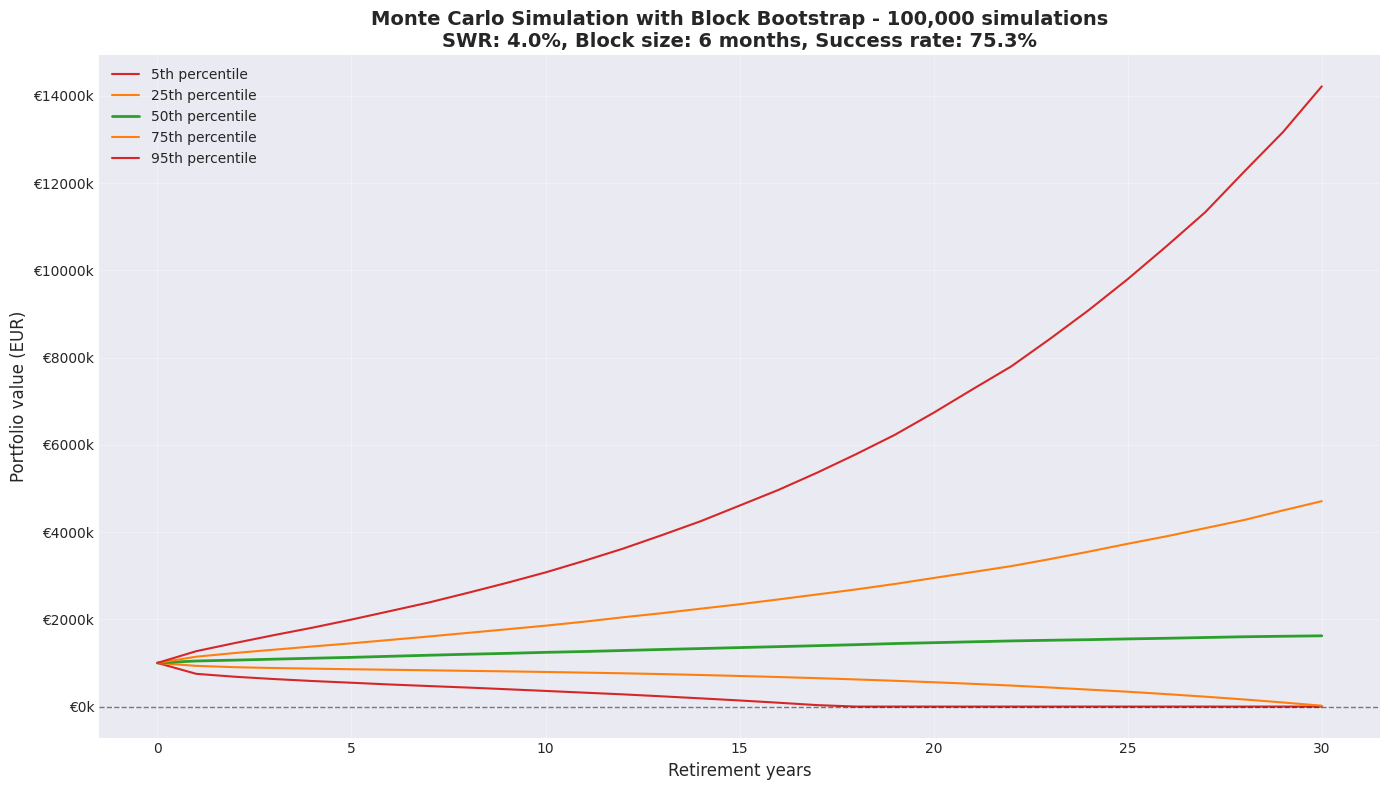

In [12]:
# Portfolio evolution plot
fig, ax = plt.subplots(figsize=(14, 8))

years = np.arange(0, RETIREMENT_YEARS + 1)

# Percentiles
percentiles = [5, 25, 50, 75, 95]
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#ff7f0e', '#d62728']

for i, p in enumerate(percentiles):
    values = np.percentile(portfolios, p, axis=0)
    ax.plot(years, values, label=f'{p}th percentile', 
            color=colors[i], linewidth=2 if p == 50 else 1.5)

# Zero line
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Retirement years', fontsize=12)
ax.set_ylabel('Portfolio value (EUR)', fontsize=12)
ax.set_title(
    f'Monte Carlo Simulation with Block Bootstrap - {N_SIMULATIONS:,} simulations\n'
    f'SWR: {ANNUAL_WITHDRAWAL_RATE:.1%}, Block size: {BLOCK_SIZE_MONTHS} months, Success rate: {success_rate:.1%}',
    fontsize=14, fontweight='bold'
)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}k'))

plt.tight_layout()
plt.show()

### Final Portfolio Values Distribution

Histogram showing distribution of portfolio values after 30 years:
- Values **below zero** (left of red line): Failed scenarios
- Values **above zero**: Successful scenarios
- **Green line**: Median final value

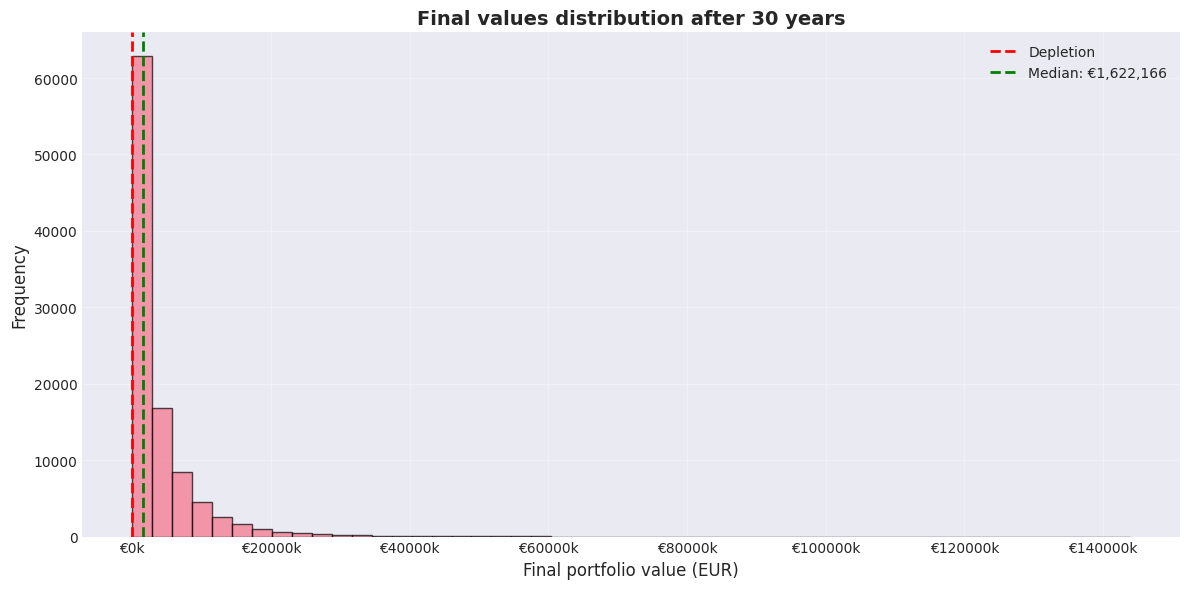

In [13]:
# Final values distribution
fig, ax = plt.subplots(figsize=(12, 6))

final_values = portfolios[:, -1]
ax.hist(final_values, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Depletion')
ax.axvline(x=np.median(final_values), color='green', linestyle='--', 
           linewidth=2, label=f'Median: €{np.median(final_values):,.0f}')

ax.set_xlabel('Final portfolio value (EUR)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(
    f'Final values distribution after {RETIREMENT_YEARS} years',
    fontsize=14, fontweight='bold'
)
ax.legend()
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}k'))

plt.tight_layout()
plt.show()

---

## 10. Sensitivity Analysis

### Withdrawal Rate Impact
Testing withdrawal rates from 2% to 5% (in 0.1% increments) to understand:
- How success rate changes with withdrawal rate
- What is the maximum sustainable withdrawal rate?
- Trade-off between spending and portfolio longevity

**Expected runtime**: 15-30 minutes (10 different rates × 100,000 simulations each)

In [14]:
# Test different withdrawal rates
withdrawal_rates = np.arange(0.02, 0.051, 0.001)
success_rates = []

print("Testing different withdrawal rates...")
for wr in withdrawal_rates:
    print(f"\nWithdrawal rate: {wr:.1%}")
    _, sr = run_monte_carlo_bootstrap(
        N_SIMULATIONS,
        INITIAL_PORTFOLIO,
        wr,
        RETIREMENT_YEARS,
        returns_df,
        BLOCK_SIZE_MONTHS
    )
    success_rates.append(sr)
    print(f"  Success rate: {sr:.2%}")

# Create results DataFrame
df_wr = pd.DataFrame({
    'Withdrawal_Rate': withdrawal_rates,
    'Success_Rate': success_rates
})

print("\nSummary:")
print(df_wr)

Testing different withdrawal rates...

Withdrawal rate: 2.0%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007961273193359375s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05376625061035156s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05637717247009277s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jo

  Success rate: 97.43%

Withdrawal rate: 2.1%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Batch computation too fast (0.07298016548156738s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09692120552062988s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16242122650146484s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 10320 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-

  Success rate: 96.92%

Withdrawal rate: 2.2%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06489348411560059s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0913088321685791s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16231656074523926s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]

  Success rate: 96.37%

Withdrawal rate: 2.3%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Batch computation too fast (0.0613255500793457s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09012937545776367s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16762638092041016s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 10320 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1

  Success rate: 95.70%

Withdrawal rate: 2.4%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007954835891723633s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05113410949707031s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05993366241455078s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jo

  Success rate: 94.98%

Withdrawal rate: 2.5%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007298469543457031s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.048300743103027344s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0631568431854248s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jo

  Success rate: 94.23%

Withdrawal rate: 2.6%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07665824890136719s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08403587341308594s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19178533554077148s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)

  Success rate: 93.43%

Withdrawal rate: 2.7%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07839226722717285s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09026336669921875s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17858433723449707s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)

  Success rate: 92.52%

Withdrawal rate: 2.8%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007915019989013672s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05171561241149902s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06000089645385742s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jo

  Success rate: 91.51%

Withdrawal rate: 2.9%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07229733467102051s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09829831123352051s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17524218559265137s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)

  Success rate: 90.49%

Withdrawal rate: 3.0%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06306242942810059s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09744882583618164s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1633458137512207s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]

  Success rate: 89.38%

Withdrawal rate: 3.1%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007399797439575195s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.049558162689208984s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05824613571166992s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_j

  Success rate: 88.16%

Withdrawal rate: 3.2%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07030987739562988s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10193562507629395s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17829680442810059s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)

  Success rate: 86.91%

Withdrawal rate: 3.3%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06891107559204102s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10431575775146484s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16882896423339844s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)

  Success rate: 85.65%

Withdrawal rate: 3.4%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.00708460807800293s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05287361145019531s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05723237991333008s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_job

  Success rate: 84.28%

Withdrawal rate: 3.5%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0082244873046875s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04688572883605957s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05633997917175293s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs

  Success rate: 82.96%

Withdrawal rate: 3.6%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.008491277694702148s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04922294616699219s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06118297576904297s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jo

  Success rate: 81.51%

Withdrawal rate: 3.7%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07409262657165527s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0978860855102539s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16489100456237793s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]

  Success rate: 79.96%

Withdrawal rate: 3.8%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06247401237487793s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09717798233032227s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17507290840148926s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)

  Success rate: 78.46%

Withdrawal rate: 3.9%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06928849220275879s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09340810775756836s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4816 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6672 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed:

  Success rate: 76.92%

Withdrawal rate: 4.0%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07238006591796875s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09590578079223633s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1672205924987793s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]

  Success rate: 75.33%

Withdrawal rate: 4.1%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07907915115356445s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09173750877380371s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17049503326416016s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)

  Success rate: 73.78%

Withdrawal rate: 4.2%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007501125335693359s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05363345146179199s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06372785568237305s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jo

  Success rate: 72.18%

Withdrawal rate: 4.3%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0667264461517334s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09875750541687012s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17687034606933594s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]

  Success rate: 70.47%

Withdrawal rate: 4.4%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0679483413696289s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0985264778137207s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16907835006713867s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]:

  Success rate: 68.78%

Withdrawal rate: 4.5%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1445159912109375s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06736421585083008s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10248136520385742s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.166428804397583s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:  

  Success rate: 67.08%

Withdrawal rate: 4.6%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06956648826599121s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1112830638885498s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16611742973327637s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]

  Success rate: 65.33%

Withdrawal rate: 4.7%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07263970375061035s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09307622909545898s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17836761474609375s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)

  Success rate: 63.62%

Withdrawal rate: 4.8%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.008201360702514648s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05429697036743164s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.059187889099121094s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_j

  Success rate: 61.80%

Withdrawal rate: 4.9%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06416201591491699s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10198807716369629s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.18553543090820312s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)

  Success rate: 60.03%

Withdrawal rate: 5.0%
  Running 100,000 simulations using all available CPU(s)...
  Base seed: 42 (reproducible)


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06862139701843262s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09407615661621094s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.169142484664917s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 8464 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]:

  Success rate: 58.30%

Summary:
    Withdrawal_Rate  Success_Rate
0             0.020       0.97432
1             0.021       0.96923
2             0.022       0.96368
3             0.023       0.95699
4             0.024       0.94983
5             0.025       0.94227
6             0.026       0.93431
7             0.027       0.92520
8             0.028       0.91507
9             0.029       0.90487
10            0.030       0.89383
11            0.031       0.88156
12            0.032       0.86907
13            0.033       0.85645
14            0.034       0.84278
15            0.035       0.82963
16            0.036       0.81506
17            0.037       0.79959
18            0.038       0.78456
19            0.039       0.76923
20            0.040       0.75333
21            0.041       0.73785
22            0.042       0.72176
23            0.043       0.70469
24            0.044       0.68782
25            0.045       0.67084
26            0.046       0.65332
27            0

[Parallel(n_jobs=-1)]: Done 100000 out of 100000 | elapsed:   16.0s finished


### Sensitivity Curve

This chart shows the relationship between withdrawal rate and success probability:
- **99% threshold** (green): Conservative safety level
- **95% threshold** (orange): Moderate safety level
- **90% threshold** (red): Acceptable risk level
- Find the withdrawal rate that meets your risk tolerance

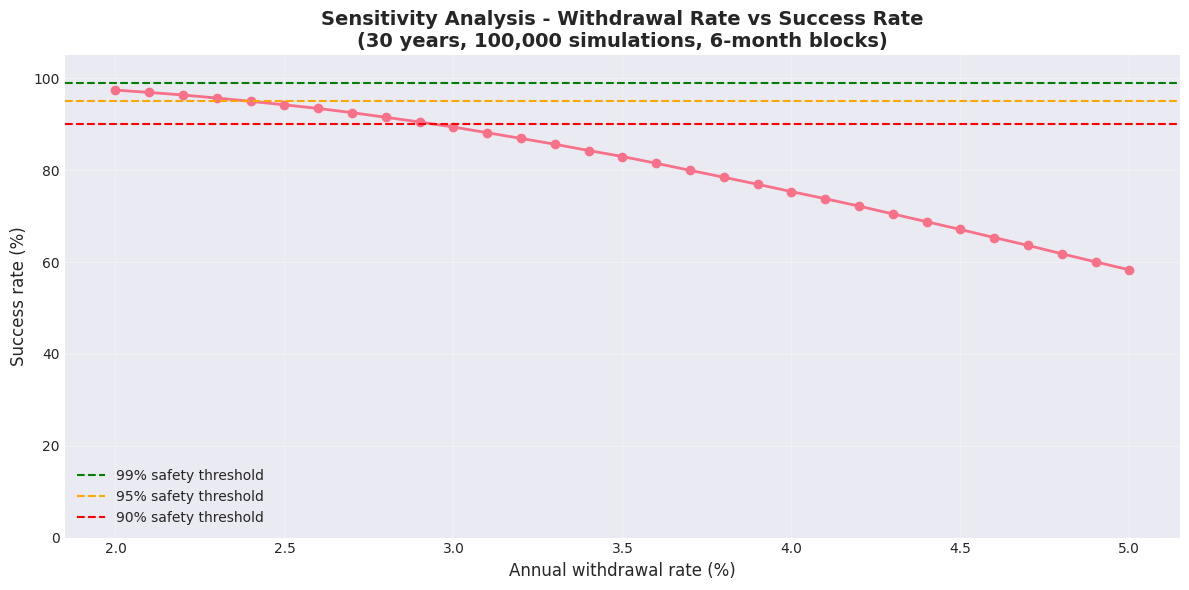

In [15]:
# Withdrawal rate sensitivity plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(withdrawal_rates * 100, np.array(success_rates) * 100, 
        marker='o', linewidth=2, markersize=6)
ax.axhline(y=99, color='green', linestyle='--', label='99% safety threshold')
ax.axhline(y=95, color='orange', linestyle='--', label='95% safety threshold')
ax.axhline(y=90, color='red', linestyle='--', label='90% safety threshold')

ax.set_xlabel('Annual withdrawal rate (%)', fontsize=12)
ax.set_ylabel('Success rate (%)', fontsize=12)
ax.set_title(
    f'Sensitivity Analysis - Withdrawal Rate vs Success Rate\n'
    f'({RETIREMENT_YEARS} years, {N_SIMULATIONS:,} simulations, {BLOCK_SIZE_MONTHS}-month blocks)',
    fontsize=14, fontweight='bold'
)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()

---

## 11. Detailed Statistical Analysis

### Year-by-Year Statistics
For each year of retirement, showing:
- **Median/Mean**: Central tendency
- **P5/P25/P75/P95**: Distribution spread
- **Failure_Prob**: Cumulative probability of depletion by that year

In [16]:
# Calculate statistics for each year
stats_df = pd.DataFrame({
    'Year': range(RETIREMENT_YEARS + 1),
    'Median': np.median(portfolios, axis=0),
    'Mean': np.mean(portfolios, axis=0),
    'P5': np.percentile(portfolios, 5, axis=0),
    'P25': np.percentile(portfolios, 25, axis=0),
    'P75': np.percentile(portfolios, 75, axis=0),
    'P95': np.percentile(portfolios, 95, axis=0),
    'Failure_Prob': np.sum(portfolios <= 0, axis=0) / N_SIMULATIONS
})

print("Portfolio evolution statistics (first 10 years):")
print(stats_df.head(11).to_string(index=False))

print("\nPortfolio evolution statistics (last 10 years):")
print(stats_df.tail(10).to_string(index=False))

Portfolio evolution statistics (first 10 years):
 Year       Median         Mean             P5            P25          P75          P95  Failure_Prob
    0 1.000000e+06 1.000000e+06 1000000.000000 1000000.000000 1.000000e+06 1.000000e+06       0.00000
    1 1.044999e+06 1.032687e+06  750567.646641  932931.925281 1.142656e+06 1.269600e+06       0.00000
    2 1.064982e+06 1.067479e+06  683422.787573  902717.568223 1.228408e+06 1.457193e+06       0.00000
    3 1.086698e+06 1.103994e+06  631219.273076  883415.044377 1.303409e+06 1.637244e+06       0.00000
    4 1.108328e+06 1.141811e+06  585689.260596  869642.286124 1.378166e+06 1.809523e+06       0.00000
    5 1.128194e+06 1.181363e+06  546402.828589  855751.493501 1.449836e+06 1.994471e+06       0.00000
    6 1.152973e+06 1.225585e+06  505840.817835  844006.917317 1.528574e+06 2.189900e+06       0.00000
    7 1.177105e+06 1.270522e+06  470282.481561  831754.945375 1.606987e+06 2.386999e+06       0.00000
    8 1.199913e+06 1.318476e+06  

### Failure Analysis

For simulations that failed (portfolio depleted), analyze:
- **When** did the portfolio run out?
- Distribution of depletion years
- Median/mean time to failure

**Interpretation**: 
- Early failures (years 1-10): Very unlucky market sequence
- Mid failures (years 10-20): Combination of poor returns and high withdrawals
- Late failures (years 20-30): Nearly made it, close call

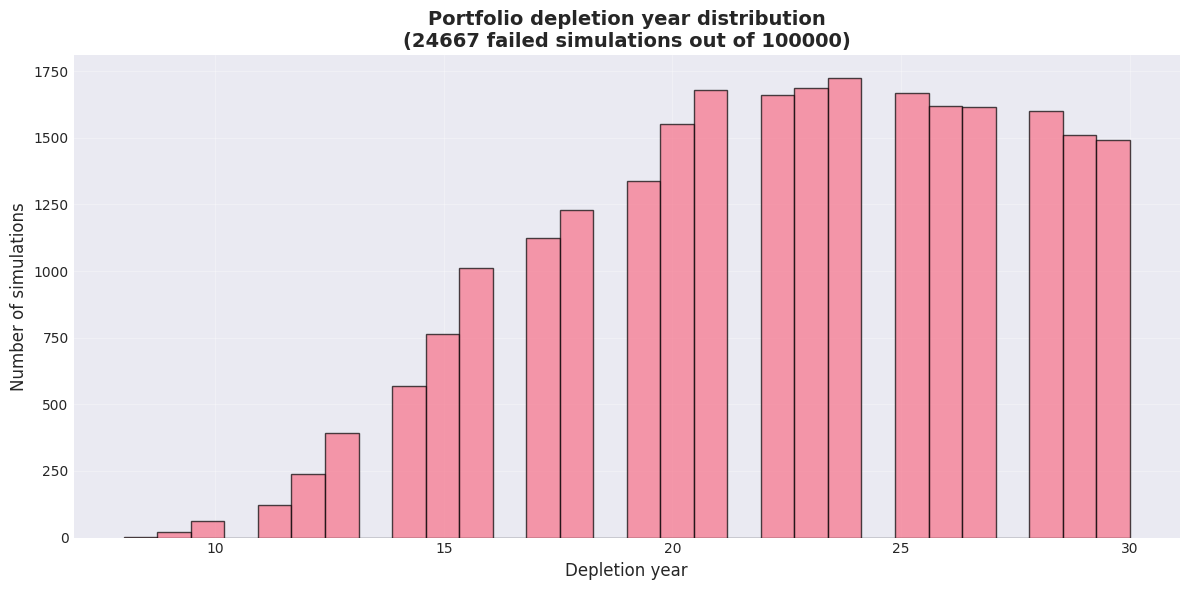


Median depletion year: 23
Mean depletion year: 22.5


In [17]:
# Depletion year for failed simulations
depletion_years = []
for portfolio in portfolios:
    if portfolio[-1] <= 0:
        depletion_year = np.where(portfolio <= 0)[0]
        if len(depletion_year) > 0:
            depletion_years.append(depletion_year[0])

if depletion_years:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(depletion_years, bins=RETIREMENT_YEARS, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Depletion year', fontsize=12)
    ax.set_ylabel('Number of simulations', fontsize=12)
    ax.set_title(
        f'Portfolio depletion year distribution\n'
        f'({len(depletion_years)} failed simulations out of {N_SIMULATIONS})',
        fontsize=14, fontweight='bold'
    )
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nMedian depletion year: {np.median(depletion_years):.0f}")
    print(f"Mean depletion year: {np.mean(depletion_years):.1f}")
else:
    print("\nNo simulation resulted in portfolio depletion!")

---

## 12. Summary and Conclusions

Comprehensive summary of simulation results including:
- Portfolio configuration
- Historical data period used
- Success rate and percentile outcomes
- Failure statistics (if any)

### Key Takeaways
1. **Success Rate**: Indicates robustness of 4% withdrawal rate for this portfolio
2. **Percentiles**: Show range of possible outcomes
3. **Sensitivity**: Identifies maximum sustainable withdrawal rate
4. **Failures**: Understand downside risks and scenarios

### Important Caveat: No Tax Assumption
This analysis assumes **no capital gains tax** is applied on withdrawals. In practice:
- Italian investors face a 26% capital gains tax on financial gains
- This would reduce the effective withdrawal rate or require higher gross withdrawals
- Tax-advantaged accounts (where available) would more closely match these results

In [18]:
print("=" * 70)
print("MONTE CARLO SIMULATION SUMMARY (BLOCK BOOTSTRAP)")
print("=" * 70)
print(f"Simulation parameters:")
print(f"  - Initial portfolio: €{INITIAL_PORTFOLIO:,}")
print(f"  - Withdrawal rate: {ANNUAL_WITHDRAWAL_RATE:.1%}")
print(f"  - Retirement duration: {RETIREMENT_YEARS} years")
print(f"  - Number of simulations: {N_SIMULATIONS:,}")
print(f"  - Block size: {BLOCK_SIZE_MONTHS} months")
print(f"  - Capital gains tax: None (tax-free withdrawals)")
print(f"\nPortfolio composition:")
for asset, weight in PORTFOLIO_WEIGHTS.items():
    print(f"  - {asset}: {weight:.1%}")
print(f"\nInflation series: {INFLATION_SERIES}")
print(f"\nHistorical data period:")
print(f"  - From: {returns_df['date'].min()}")
print(f"  - To: {returns_df['date'].max()}")
print(f"  - Total days: {len(returns_df):,}")
print(f"\nResults:")
print(f"  - Success rate: {success_rate:.2%}")
print(f"  - Median final value: €{np.median(portfolios[:, -1]):,.0f}")
print(f"  - P5 final value: €{np.percentile(portfolios[:, -1], 5):,.0f}")
print(f"  - P95 final value: €{np.percentile(portfolios[:, -1], 95):,.0f}")
if depletion_years:
    print(f"  - Failed simulations: {len(depletion_years)} ({len(depletion_years)/N_SIMULATIONS:.1%})")
    print(f"  - Median depletion year: {np.median(depletion_years):.0f}")
print("=" * 70)
print("\n⚠️  NOTE: This simulation assumes NO capital gains tax on withdrawals.")
print("    In taxed scenarios, effective withdrawal rates would be lower.")

MONTE CARLO SIMULATION SUMMARY (BLOCK BOOTSTRAP)
Simulation parameters:
  - Initial portfolio: €1,000,000
  - Withdrawal rate: 4.0%
  - Retirement duration: 30 years
  - Number of simulations: 100,000
  - Block size: 6 months
  - Capital gains tax: None (tax-free withdrawals)

Portfolio composition:
  - MSCI_WORLD: 100.0%

Inflation series: HICP_EU

Historical data period:
  - From: 2000-12-30 00:00:00
  - To: 2025-12-03 00:00:00
  - Total days: 9,105

Results:
  - Success rate: 75.33%
  - Median final value: €1,622,166
  - P5 final value: €0
  - P95 final value: €14,217,766
  - Failed simulations: 24667 (24.7%)
  - Median depletion year: 23

⚠️  NOTE: This simulation assumes NO capital gains tax on withdrawals.
    In taxed scenarios, effective withdrawal rates would be lower.
